# Example 4: Inverse estimation of soil hydraulic properties using Phydrus and MCMC 
*Authors: M. Vremec & R.A. Collenteur*

---
This notebook is part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, et. al. (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

---
In this Notebook the model constructed in the previous example is extended for inverse estimation of soil hydrauilic properties 

1. generation of Synthethic Data by Forward Simulation 
2. inverse estimation of soil hydraulic properties using cumulative outflow, profile-averaged water content and matric head data in the objective function
---
In this notebook it is shown how the MCMC-algorithm can be used to estimate the soil hydrauilic properties for a Phydrus model. Apart from Phydrus being installed, the following Python Packages have to be installed:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [lmfit](https://lmfit.github.io/lmfit-py/)
- [corner](https://corner.readthedocs.io)

### 1. Import the Pydrus package

In [2]:
# Import the necessary modules
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import phydrus as ps
import corner
import lmfit
import emcee

### 2. Generation of Synthethic Data by Forward Simulation
In the following code block we recreate the model developed in Example 1. We add solute transport to the model to calculate the water ages.

In [ ]:
#Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "hydrus.exe")
# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              mass_units="mmol", time_unit="days", length_unit="cm")

ml.add_time_info(tinit=0, tmax=730, dtmin=1e-3, print_times=True);
ml.add_waterflow(top_bc=3, bot_bc=4)
ml.time_info["lPrint"] = False
# Add materials
m = ml.get_empty_material_df(n=1)
m.loc[[1]] = [[0.0, 0.3579, 0.0145, 1.5234, 50, 0.5]]
ml.add_material(m)

# Define loop for potential root water uptake distribution proposed by Hoffman and Van Genuchten
def z_loop(z, r1=10, r2=20):
    if z > -r1:
        return 1
    elif z < -(r1 + r2):
        return 0
    else:
        return(z + (r1 + r2)) / r2

bottom = -100  # Depth of the soil column
nodes = 150  # Dictretize into n nodes
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=1)
profile["Beta"] = profile.apply(lambda row: z_loop(row["x"]), axis=1)
ml.add_profile(profile)

ml.add_root_uptake(model=0, crootmax=100, omegac=0, p2h=-1500, p2l=-1500, poptm=[-25])

ml.add_obs_nodes([-30])

atm = pd.read_csv("data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

# Write the input and check if the model simulates
ml.write_input()
ml.simulate();

C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\model.py:492: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.51 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.37 0.   0.   0.13 1.88 0.95 0.   0.01 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.21 0.   0.04 0.   0.
 0.68 1.59 0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09
 0.8  0.   0.03 0.   0.18 0.   0.   0.   0.   0.   2.26 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   3.5  0.91 0.   0.   0.41 2.28 0.03
 0.01 0.   0.   0.   0.   0.05 0.07 0.07 0.08 0.14 0.   0.   0.2  0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.18 0.   0.   0.   0.03 0.   0.   0.   0.   2.77 0.07 0.35
 0.   0.19 0.09 0.   0.   1.5  0.   0.   1.7  0.   0.3  0.   0.   0.82
 0.01 0.1  0.22 0.01 0.   0.   0.26 1.01 2.29 0.57 0.   0.   0.   0.
 0.18 2.85 0.15 0.01 0.2  0

c:\Users\alengrand\OneDrive - UCL\Documents\GitHub\phydrus\examples\phydrus_paper\Ex3\hydrus.exe


INFO: Hydrus-1D Simulation Successful.


Time to write the input files:

In [17]:
#%%timeit
ml.write_input()

INFO: Successfully wrote output\SELECTOR.IN
INFO: Successfully wrote output\PROFILE.DAT
INFO: Successfully wrote output\ATMOSPH.IN


Time to execute Hydrus-1D:

In [18]:
#%%timeit
ml.simulate()

INFO: Hydrus-1D Simulation Successful.


CompletedProcess(args=['c:\\Users\\alengrand\\OneDrive - UCL\\Documents\\GitHub\\phydrus\\examples\\phydrus_paper\\Ex3\\hydrus.exe', 'output', '-1'], returncode=0)

### 3. Plot the seepage, averaged water content and matric potential over time

In [19]:
# extract cumulative outflow, averaged SWC, matric head at 30 cm
cum_bottom = ml.read_tlevel()["sum(vBot)"]
volume = ml.read_tlevel()["Volume"]
m_head = ml.read_obs_node()[31]["h"]

C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWar

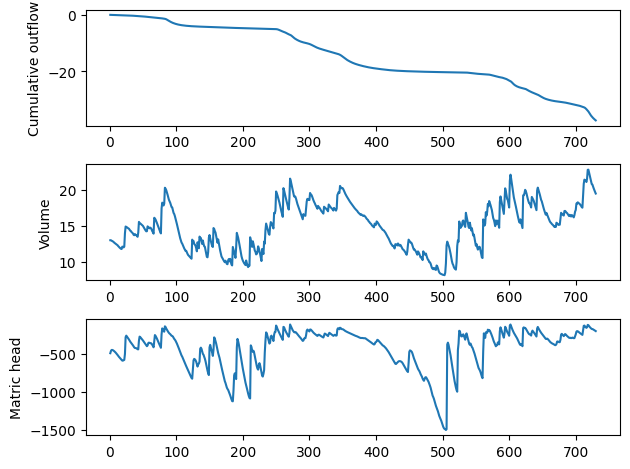

In [20]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom)
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].set_ylabel("Matric head")
plt.tight_layout()

### 4. Use lmfit least squares (Marquedt-Levenberg) method to estimate initial conditions

In [21]:
# define function to execute Hydrus and compute residuals
def residual(pars, data=None):
    params = pars.valuesdict()
    ks=params["ks"]
    n=params["n"]
    alfa = params["Alfa"]
    ths=params["ths"]
    m = ml.get_empty_material_df(n=1)
    m.loc[[1]] = [[0.0, ths, alfa, n, ks, 0.5]]
    ml.add_material(m)
    ml.write_input()
    ml.simulate()

    sum_seep=np.asarray(ml.read_tlevel()["sum(vBot)"])
    volume = ml.read_tlevel()["Volume"]
    
    if len(sum_seep)<(len(data)/2):
        print("Hydrus-1D model did not converge under the next given parameters:", ths, alfa, n, ks)
        return data
    else:
        of = np.concatenate([np.asarray(sum_seep), np.asarray(volume)])
        residual = of-data
        return np.asarray(residual)

In [22]:
# Determine initial, lower and upper boundaries of soil hydraulic properties for the inverse parameter optimization strategies
params = lmfit.Parameters()
params.add("ths", value=0.39, min=0.3, max=0.52)  # Sandy Clay Loam - soil catalog
params.add("Alfa", value=0.059, min=0.006, max=0.22)
params.add("n", value=1.48, min=1.2, max=1.7)
params.add("ks", value=31, min=15, max=1000)
out = lmfit.minimize(residual, params,
                kws={'data': np.asarray(np.concatenate([np.asarray(cum_bottom), np.asarray(volume)]))},method="leastsq", epsfcn=1e-6)
out

INFO: Successfully wrote output\SELECTOR.IN
INFO: Successfully wrote output\PROFILE.DAT
INFO: Successfully wrote output\ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` inst

In [23]:
# extract bottom flux, volume, matric head
cum_bottom1 = ml.read_tlevel()["sum(vBot)"]
volume1 = ml.read_tlevel()["Volume"]
m_head1 = ml.read_obs_node()[31]["h"]

C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWar

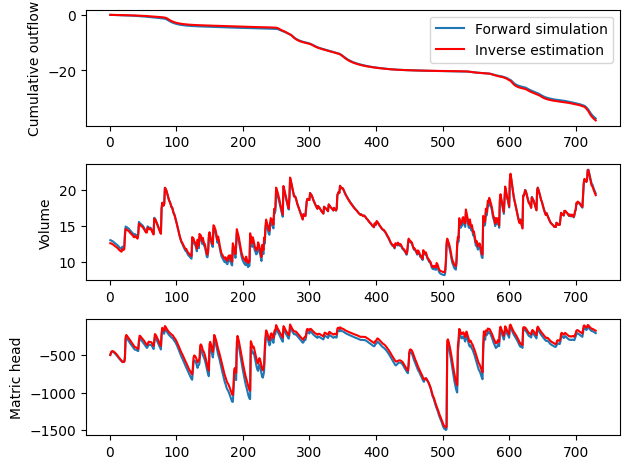

In [24]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom, label="Forward simulation")
ax[0].plot(cum_bottom1, color="red", label="Inverse estimation")
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].plot(volume1, color="red")
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].plot(m_head1, color="red")
ax[2].set_ylabel("Matric head")
ax[0].legend()
plt.tight_layout()

### 5. Use EMCEE for inverse estimation

In [25]:
# Determine initial, lower and upper boundaries of soil hydraulic properties for the inverse parameter optimization strategies
params = lmfit.Parameters()
params.add("ths", value=out.params["ths"].value, min=0.3, max=0.52)
params.add("Alfa", value=out.params["Alfa"].value, min=0.006, max=0.22)
params.add("n", value=out.params["n"].value, min=1.2, max=1.7)
params.add("ks", value=out.params["ks"].value, min=15, max=1000)
out_emcee = lmfit.minimize(residual, params, kws={'data': np.asarray(np.concatenate([np.asarray(cum_bottom), np.asarray(volume)]))},
                     method="emcee", steps=200, burn=10, thin=5, is_weighted=True)
out_emcee

INFO: Successfully wrote output\SELECTOR.IN
INFO: Successfully wrote output\PROFILE.DAT
INFO: Successfully wrote output\ATMOSPH.IN


lmfit version: 1.3.2
emcee version: 3.0.0


INFO: Hydrus-1D Simulation Successful.
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-

emcee: Exception while calling your likelihood function:
  params: [3.63386939e-01 2.31080409e-02 1.44726838e+00 1.07978299e+02]
  args: (<function residual at 0x0000027120828AE0>, Parameters([('ths', <Parameter 'ths', value=np.float64(0.363386939396924), bounds=[0.3:0.52]>), ('Alfa', <Parameter 'Alfa', value=np.float64(0.023108040883759715), bounds=[0.006:0.22]>), ('n', <Parameter 'n', value=np.float64(1.447268381527709), bounds=[1.2:1.7]>), ('ks', <Parameter 'ks', value=np.float64(107.97829850692519), bounds=[15:1000]>)]), ['ths', 'Alfa', 'n', 'ks'], array([[3.0e-01, 5.2e-01],
       [6.0e-03, 2.2e-01],
       [1.2e+00, 1.7e+00],
       [1.5e+01, 1.0e+03]]))
  kwargs: {'is_weighted': True, 'float_behavior': 'posterior', 'userargs': [], 'userkws': {'data': array([-8.0610e-03, -1.6122e-02, -2.4183e-02, ...,  1.9931e+01,
        1.9706e+01,  1.9481e+01])}, 'nan_policy': 'raise'}
  exception:


Traceback (most recent call last):
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\emcee\ensemble.py", line 546, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\lmfit\minimizer.py", line 1069, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "C:\Users\alengrand\AppData\Local\Temp\ipykernel_12824\1014169534.py", line 12, in residual
    ml.simulate()
    ~~~~~~~~~~~^^
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\model.py", line 989, in simulate
    result = run(cmd)
  File "c:\Program Files\Python313\Lib\subprocess.py", line 556, in run
    stdout, stderr = process.communicate(input, timeout=timeout)
                     ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1211, in communicate
    self.wait()
    ~~~~~~~~~^

KeyboardInterrupt: 

In [26]:
# Determine initial, lower and upper boundaries of soil hydraulic properties for the inverse parameter optimization strategies
print("lmfit version:", lmfit.__version__)
print("emcee version:", emcee.__version__)
params = lmfit.Parameters()
params.add("ths", value=out.params["ths"].value, min=0.3, max=0.52)
params.add("Alfa", value=out.params["Alfa"].value, min=0.006, max=0.22)
params.add("n", value=out.params["n"].value, min=1.2, max=1.7)
params.add("ks", value=out.params["ks"].value, min=15, max=1000)
out_emcee = lmfit.minimize(residual, params, kws={'data': np.asarray(np.concatenate([np.asarray(cum_bottom), np.asarray(volume)]))},
                     method="emcee", steps=200, burn=10, thin=5, is_weighted=True)
out_emcee

INFO: Successfully wrote output\SELECTOR.IN
INFO:phydrus.model:Successfully wrote output\SELECTOR.IN
INFO: Successfully wrote output\PROFILE.DAT
INFO:phydrus.model:Successfully wrote output\PROFILE.DAT
INFO: Successfully wrote output\ATMOSPH.IN
INFO:phydrus.model:Successfully wrote output\ATMOSPH.IN


lmfit version: 1.3.2
emcee version: 3.0.0


INFO: Hydrus-1D Simulation Successful.
INFO:phydrus.model:Hydrus-1D Simulation Successful.
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Us

emcee: Exception while calling your likelihood function:
  params: [3.63433866e-01 2.31045618e-02 1.44705478e+00 1.07950014e+02]
  args: (<function residual at 0x0000027120828AE0>, Parameters([('ths', <Parameter 'ths', value=np.float64(0.36343386599561667), bounds=[0.3:0.52]>), ('Alfa', <Parameter 'Alfa', value=np.float64(0.02310456182006279), bounds=[0.006:0.22]>), ('n', <Parameter 'n', value=np.float64(1.4470547790673627), bounds=[1.2:1.7]>), ('ks', <Parameter 'ks', value=np.float64(107.95001384337935), bounds=[15:1000]>)]), ['ths', 'Alfa', 'n', 'ks'], array([[3.0e-01, 5.2e-01],
       [6.0e-03, 2.2e-01],
       [1.2e+00, 1.7e+00],
       [1.5e+01, 1.0e+03]]))
  kwargs: {'is_weighted': True, 'float_behavior': 'posterior', 'userargs': [], 'userkws': {'data': array([-8.0610e-03, -1.6122e-02, -2.4183e-02, ...,  1.9931e+01,
        1.9706e+01,  1.9481e+01])}, 'nan_policy': 'raise'}
  exception:


Traceback (most recent call last):
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\emcee\ensemble.py", line 546, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\lmfit\minimizer.py", line 1069, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "C:\Users\alengrand\AppData\Local\Temp\ipykernel_12824\1014169534.py", line 12, in residual
    ml.simulate()
    ~~~~~~~~~~~^^
  File "C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\model.py", line 989, in simulate
    result = run(cmd)
  File "c:\Program Files\Python313\Lib\subprocess.py", line 556, in run
    stdout, stderr = process.communicate(input, timeout=timeout)
                     ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1211, in communicate
    self.wait()
    ~~~~~~~~~^

KeyboardInterrupt: 

In [27]:
out_emcee

NameError: name 'out_emcee' is not defined

In [28]:
cum_bottom2 = ml.read_tlevel()["sum(vBot)"]
volume2 = ml.read_tlevel()["Volume"]
m_head2 = ml.read_obs_node()[31]["h"]

C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWar

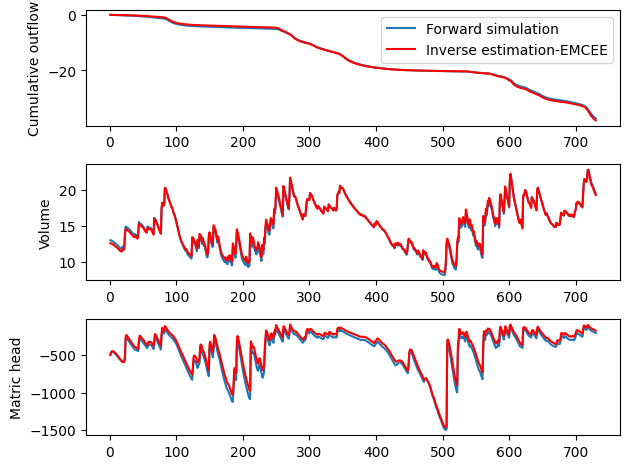

In [29]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom, label="Forward simulation")
ax[0].plot(cum_bottom2, color="red", label="Inverse estimation-EMCEE")
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].plot(volume2, color="red")
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].plot(m_head2, color="red")
ax[2].set_ylabel("Matric head")
ax[0].legend()
plt.tight_layout()

In [30]:
# functions to save and import lmfit.minimizer results
def save_minimizer(minimizerresult, filename):
    """minimizerresult: MinimizerResult object"""
    with open(filename, 'w') as fp:
        fp.write(str(minimizerresult.var_names) + "\n" + (str(list(minimizerresult.params.valuesdict().values()))+ "\n"))
    minimizerresult.flatchain.to_csv(filename, mode='a', sep=";")
def import_minimizer(filename):
    """minimizerresult: MinimizerResult object"""
    f=open(filename)
    lines=f.readlines()
    labels = lines[0]
    truths = lines[1]
    df = pd.read_csv(filename, skiprows=2, index_col=0, sep=";")
    return df, labels, truths

## 6. Visualize the results
The results are a Pandas DataFrame with $n$ the parameter samples, whgere $n$ is calculated as follows:

$n = \frac{(\text{steps}-\text{burn})\cdot\text{nwalkers}}{\text{thin}} $

## Corner.py
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

In [31]:
# save/import minimizer results
#save_minimizer(out, "emcee_example1.csv")
df_out, labels, truths = import_minimizer("emcee_example.csv")

ValueError: Provided figure has 16 axes, but data has dimensions K=83

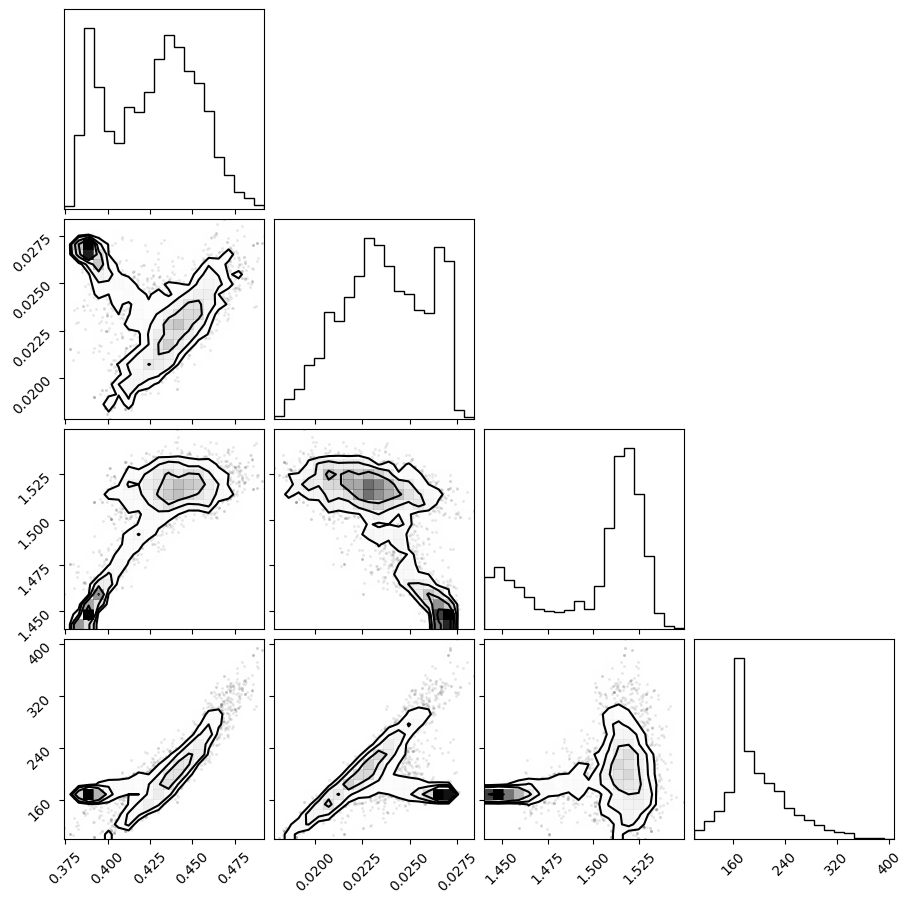

In [32]:
import corner
emcee_corner = corner.corner(df_out, truths=truths)

## 7. What happens to the walkers at each step?
The walkers take steps in different directions for each step. It is expected that after a number of steps, the direction of the step becomes random, as a sign that an optimum has been found. This can be checked by looking at the autocorrelation, which should be insignificant after a number of steps (NOT SURE HOW TO INTERPRET THIS YET). However it does not seem the case that the parameters converge to come optimum yet, even for the simple Linear model (from Collenteur, Pastas - example EMCEE Hammer).

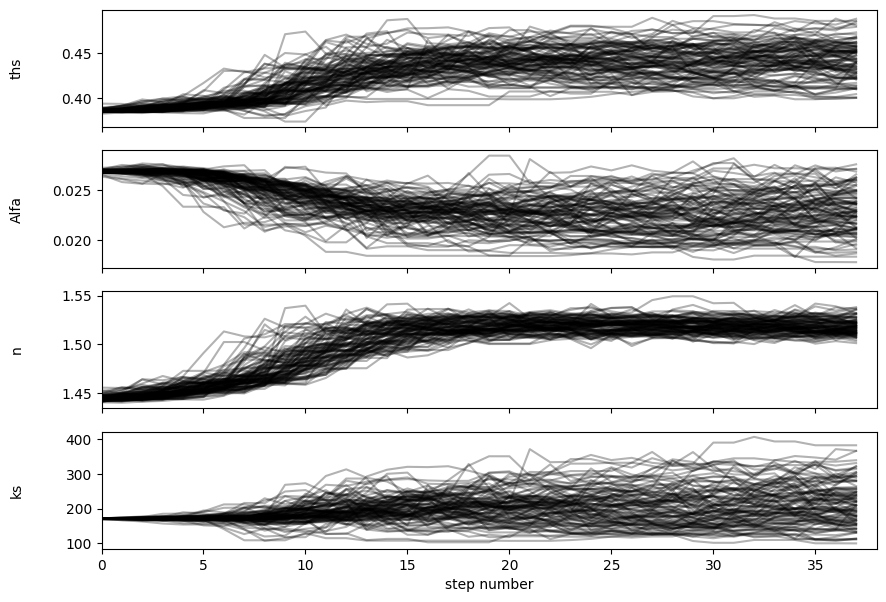

In [33]:
labels = df_out.columns

fig, axes = plt.subplots(labels.size, figsize=(10, 7), sharex=True)
samples = np.asarray(df_out).reshape(int(len(df_out)/100),100,len(df_out.columns))
for i in range(labels.size):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### 8. Plot some simulated time series to display uncertainty?

INFO: Successfully wrote output\SELECTOR.IN
INFO:phydrus.model:Successfully wrote output\SELECTOR.IN
INFO: Successfully wrote output\PROFILE.DAT
INFO:phydrus.model:Successfully wrote output\PROFILE.DAT
INFO: Successfully wrote output\ATMOSPH.IN
INFO:phydrus.model:Successfully wrote output\ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.
INFO:phydrus.model:Hydrus-1D Simulation Successful.
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\alengrand\AppData\Roaming\Python\Python313\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
C:\

Text(0, 0.5, 'Volume')

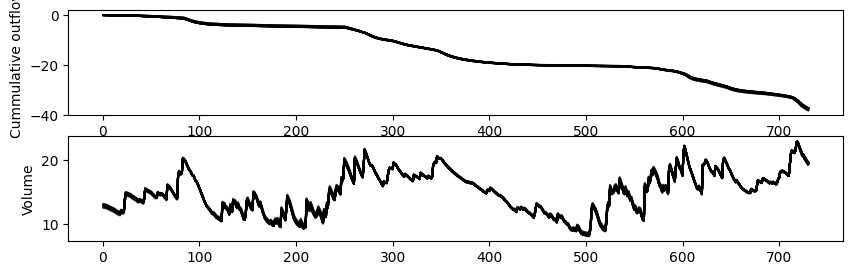

In [34]:
fig,ax = plt.subplots(nrows=2, figsize=(10,3))

inds = np.random.randint(len(df_out), size=100)
for ind in inds:
    params = df_out.iloc[ind].values
    m = ml.get_empty_material_df(n=1)
    m.loc[[1]] = [[0.0, params[0], params[1], params[2], params[3], 0.5]]
    ml.add_material(m)
    ml.write_input()
    ml.simulate()
    ax[0].plot(ml.read_tlevel()["sum(vBot)"], c="k", alpha=0.1)
    ax[1].plot(ml.read_tlevel()["Volume"], c="k", alpha=0.1)
ax[0].set_ylabel("Cummulative outflow")
ax[1].set_ylabel("Volume")